#Support Vector Machine

Support Vector Machines (SVMs) were used in this analysis because they can model nonlinear relationships through kernel functions and handle mixed numerical and categorical feature spaces after preprocessing. SVMs are effective on moderate-sized datasets and provide a comparative nonlinear benchmark alongside linear and ensemble models for predicting student performance.

In [ ]:
#key imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#Load Data
df = pd.read_csv("/content/math_train.csv")
y = df["G3"]
X = df.drop(columns=["G1", "G2", "G3"])

In [ ]:
#identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols, numeric_cols
#build preprocessing using ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)


In [ ]:
#pipeline: preprocessing -> SVR
svr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svr", SVR())
])


In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
#hyperparameter search space
svr_param_grid = {
    "svr__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "svr__C": [0.01, 0.1, 1, 10, 100],
    "svr__gamma": ["scale", "auto"]
}


In [ ]:
#CV
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
svr_grid_search = GridSearchCV(
    estimator=svr_pipeline,
    param_grid=svr_param_grid,
    cv=cv_strategy,
    scoring="r2",
    n_jobs=-1,
    verbose=2
)

svr_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet'...
      dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object'))])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': [0.01, 0.1, 1, 10, 100],
                         'svr__gamma': ['scale', 'auto'],
                         'svr__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='r2', verbose=2)

In [ ]:
#best model
print("Best parameters:", svr_grid_search.best_params_)
print("Best CV R²:", svr_grid_search.best_score_)


Best parameters: {'svr__C': 1, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best CV R²: 0.10623669065263733


- Kernel = RBF
The best-performing model uses a nonlinear kernel, meaning the algorithm tried to fit curved relationships between features and final grade.
- C = 1
A moderate C value indicates the model prefers smoother predictions and avoids overfitting by not fitting every point exactly.
- gamma = 'auto'
Gamma was set based on the number of features, resulting in a smoother and less flexible model that may underfit.
- CV R²
The model explains about 10% of the variance in G3 during cross-validation.
This is very weak predictive power, suggesting most features in the dataset have limited relationship with final grades.
SVR is struggling to find meaningful patterns during training.

In [ ]:
#evaluate on test set
best_svr = svr_grid_search.best_estimator_

y_pred = best_svr.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Test R²: -0.16029898006998566
Test MSE: 16.660035062469724
Test RMSE: 4.081670621506557
Test MAE: 2.9435397867566184


- Test R² = –0.16
The negative R² means the model performs worse than simply predicting the average grade for all students.
This indicates strong overfitting: what SVR learned from training folds does not generalize to new data.
- Test MSE = 16.66
The average squared error is relatively high given the grade range (0–20).
Large mistakes contribute heavily to this value.
- Test RMSE ≈ 4.08
On average, SVR predictions are off by about 4 grade points — a large error in this context.
- Test MAE ≈ 2.94
The model is typically 3 points away from the true grade. This confirms the model’s limited accuracy.

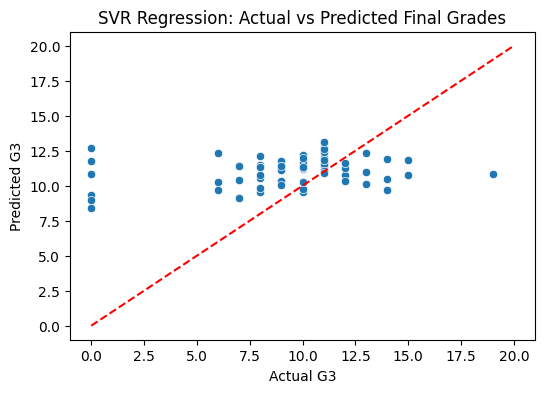

In [ ]:
#plot of actual vs predicted
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("SVR Regression: Actual vs Predicted Final Grades")
plt.plot([0,20],[0,20], color="red", linestyle="--")  # reference line
plt.show()


## Feature Importance
Traditional feature importance methods cannot be applied to this SVM model because the best-performing Support Vector Regression model uses a nonlinear RBF kernel, which does not produce interpretable coefficients or feature weights. Unlike linear models, kernel-based SVMs operate in a high-dimensional transformed space where feature contributions cannot be directly mapped back to the original input variables. As a result, the model does not provide a built-in measure of feature importance, and alternative techniques such as permutation importance are required to estimate how each feature influences the predictions.

## Need for Permutation Importance
Because nonlinear SVMs do not provide interpretable coefficients, permutation importance is used to estimate how much each feature contributes to the model’s predictions. This method works by measuring the drop in model performance when a single feature is randomly shuffled, breaking its relationship with the target. If performance decreases substantially, the feature is considered important. Permutation importance therefore offers a model-agnostic way to understand feature relevance for the RBF-kernel SVM, where direct coefficient-based interpretation is not possible.


Permutation Importances for Best SVR Model (sorted):

schoolsup_yes: 0.0783
guardian_other: 0.0276
guardian_mother: 0.0257
reason_other: 0.0137
Mjob_services: 0.0099
Fedu: 0.0079
Fjob_services: 0.0068
Mjob_other: 0.0051
paid_yes: 0.0043
Mjob_health: 0.0029
traveltime: 0.0028
romantic_yes: 0.0026
school_MS: 0.0022
goout: 0.0022
studytime: 0.0019
Fjob_other: 0.0018
address_U: 0.0011
Fjob_teacher: 0.0003
age: 0.0003
Dalc: 0.0001
health: -0.0003
Fjob_health: -0.0004
failures: -0.0005
freetime: -0.0005
famrel: -0.0006
sex_M: -0.0008
famsup_yes: -0.0009
activities_yes: -0.0009
absences: -0.0012
Pstatus_T: -0.0014
Walc: -0.0016
Mjob_teacher: -0.0017
reason_home: -0.0025
famsize_LE3: -0.0027
nursery_yes: -0.0064
Medu: -0.0091
reason_reputation: -0.0110
internet_yes: -0.0112
higher_yes: -0.0194


/tmp/ipython-input-3175992476.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df.head(20), palette="viridis")


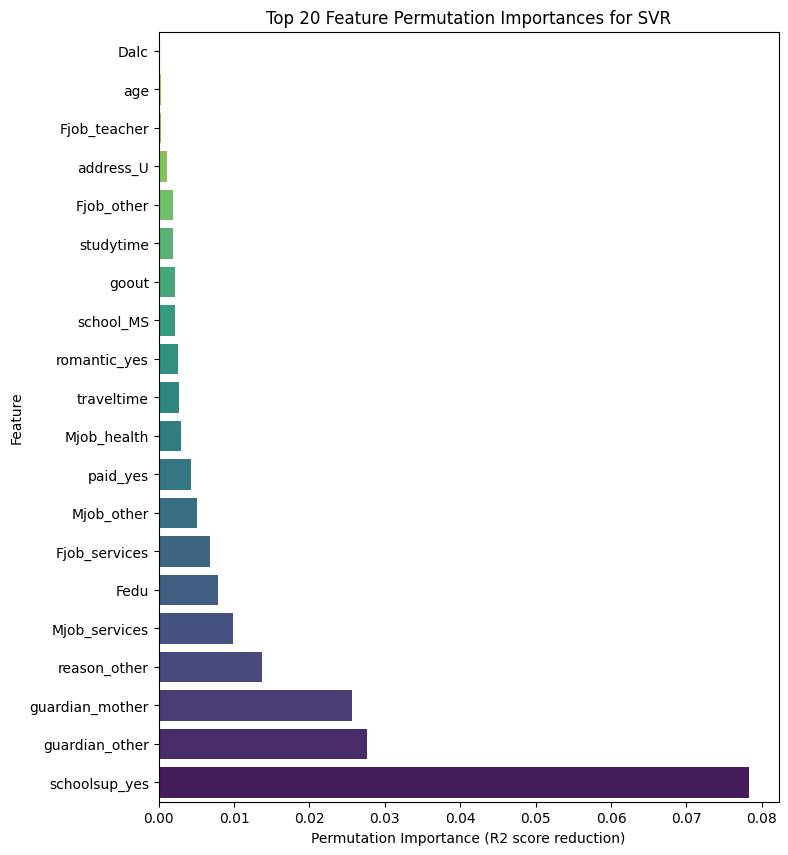

In [ ]:
# -------------------------------------------------------------
# Permutation Importance for Best SVM Model (SVR)
# -------------------------------------------------------------

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Best SVM model from GridSearchCV
best_svr = svr_grid_search.best_estimator_

# 2. Preprocess test data
X_test_processed = best_svr.named_steps["preprocess"].transform(X_test)
y_test_true = y_test.values

# 3. Extract feature names
preprocessor = best_svr.named_steps["preprocess"]

cat_encoder = preprocessor.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)

num_feature_names = numeric_cols
all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 4. Permutation importance using the SVR model inside the pipeline
result = permutation_importance(
    estimator=best_svr.named_steps["svr"], # SVR model itself
    X=X_test_processed,
    y=y_test_true,
    scoring="r2",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# 5. Build dataframe
importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": result.importances_mean
}).sort_values(by="importance", ascending=False)

# 6. Print sorted feature importances
print("\nPermutation Importances for Best SVR Model (sorted):\n")
for idx, row in importance_df.iterrows(): # Fixed SyntaxError
    print(f"{row['feature']}: {row['importance']:.4f}")

# 7. Plot top 20 important features
plt.figure(figsize=(8, 10))
sns.barplot(x="importance", y="feature", data=importance_df.head(20), palette="viridis")
plt.xlabel("Permutation Importance (R2 score reduction)")
plt.ylabel("Feature")
plt.title("Top 20 Feature Permutation Importances for SVR")
plt.gca().invert_yaxis() # Most important at the top
plt.show()

### Interpretation

- schoolsup_yes is by far the most influential predictor, indicating that removing this feature causes the greatest drop in model performance. As with Elastic Net, this likely reflects a selection effect: students receiving additional school support tend to be those who were already struggling academically.
- Guardian-related variables (guardian_other, guardian_mother) also rank highly. This suggests that who the primary caregiver is may capture important differences in household stability, involvement, or expectations that affect student performance.
reason_other, representing alternative motivations for choosing the school, has moderate importance. This may reflect underlying family priorities or contextual circumstances shaping a student's educational environment.
- Parental occupation and education variables (e.g., Mjob_services, Fjob_services, Fedu) show small but meaningful contributions, suggesting that family socioeconomic positioning continues to play a role even after controlling for other variables.
paid_yes (access to paid classes or tutoring) contributes positively, implying that additional academic resources may support student outcomes, though the effect is modest.
- romantic_yes and several lifestyle variables (goout, studytime, traveltime) have low but non-zero importance, indicating that social behavior and time allocation contribute slightly to predictive performance but are not major drivers for the SVR model.
- Many variables show very small or slightly negative importances, meaning that permuting them actually improves model performance slightly. These include:
health, freetime, famrel, sex_M
absences, failures, alcohol consumption (Dalc, Walc)
internet_yes, higher_yes, Medu, nursery_yes
- This suggests that these features provide little unique signal for SVR and may even add noise due to multicollinearity or weak nonlinear relationships.
Notably, Medu (mother’s education) has a small negative importance in SVR, despite being positive and meaningful in Elastic Net. This indicates that SVR captures different nonlinear relationships and is not relying heavily on parental education for prediction.


- In general, the SVR model relies on a smaller set of moderately informative variables, with performance dominated by:
- school support
- guardian identity
- school choice motivations
- certain parental job categories
The overall pattern suggests that SVR captures nuanced, nonlinear effects, but many individual features have minimal marginal importance due to overlapping information or weak predictive power in isolation.